In [4]:
struct Global
    nv          ::Int    #boundary point
    jx          ::Int    #cell number
    #nm          ::Int    #N of matter
    kindProblem ::Int #kind of problem
    tt          ::Float64      #total time
    cfl         ::Float64     # cfl
end

struct Const
    Y0 ::Float64
    ρ0 ::Float64
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end
    

struct Var
    ρ ::Float64
    u ::Float64
    p ::Float64
    sxx::Float64
end


$$ 1Pa = 1N/m^2 = 1 kg/(m\cdot s^2) = 10^{-11} g/(cm \cdot \mu s^2)$$ 

$$ 1 m/s = 10^{-4} cm/\mu s$$
$$ 1kg/m^3 = 10^{-3} g/cm^3$$


$$f(\eta) = \frac{(\eta-1)(\eta-\Gamma_0(\eta-1)/2)}{(\eta-s_0(\eta-1))^2}$$
$$f'(\eta) = \frac{\eta+(s_0-\Gamma_0)(\eta-1)}{(\eta-s_0(\eta-1))^3}$$

In [5]:

function fη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fη=(η-1.0)*(η-c.Γ0*(η-1.0)/2.0)/(η-c.s0*(η-1))^2
end

function fηη(ρ::Float64,c::Const)
    η = ρ/c.ρ0
    fηη=(η+(c.s0-c.Γ0)*(η-1))/(η-c.s0*(η-1))^3
end


fηη (generic function with 1 method)

Mie-Gr\"uneisen equation of state
$$e =\frac{p-\rho_0a_0^2f(\eta)}{\rho_0\Gamma_0}$$

$$p = \rho_0a_0^2f(\eta)+\rho_0\Gamma_0e$$

In [6]:
function PToe(ρ::Float64,p::Float64,con::Const)
    c=con
    ei = (p-c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function EToP(ρ::Float64,ei::Float64,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei+c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

EToP (generic function with 1 method)

$$ \begin{aligned}
    & \rho = uo[1]\\
    & u  = uo[2]\\
    & p =uo[3]\\
    & s_{xx}=uo[4]
     \end{aligned} \hspace{0.3cm}
    \begin{aligned}
    &U[1]=\rho\\
    &U[2]=\rho u\\
    &U[3]=\rho E\\
    &U[4]=s_{xx}\\
    \end{aligned}
$$

$$ e=E/\rho-\frac{1}{2}u^2$$


In [7]:
"""
 from  the primitive variables uo to  conservative variables U
"""
function UoTou(uo::Array{Float64,1},con::Const)
    u = zeros(Float64, 4)
    u[1]=uo[1]
    u[2]=uo[2]*uo[1]
    ei = PToe(uo[1],uo[3],con)
    u[3]=(ei+0.5uo[2]^2)*uo[1]
    u[4]=uo[4]
    return u
end

UoTou

In [8]:
"""
 from conservative variables U  to  the primitive variables uo
"""
function UToUo(u::Array{Float64,1},con::Const)
    uo = zeros(Float64, 4)
    uo[1]=u[1]
    uo[2]=u[2]/u[1]
    ei=u[3]/uo[1]-0.5uo[2]^2
    p = EToP(uo[1],ei,con)
    uo[3]=p
    uo[4]=u[4]
    return uo
end  

UToUo

$$ c=\sqrt{a^2-\frac{\rho_0}{\rho^2}\Gamma_0s_{xx}+\frac{4}{3}\frac{\mu}{\rho}}$$
$$ a^2= a_0^2 f'(\eta)+\frac{p}{\rho^2}\rho_0\Gamma_0$$

In [9]:
function sound(uo::Array{Float64,1},con::Const)
    a0  = con.a0
    ρ0  = con.ρ0
    Γ0  = con.Γ0
    μ   = con.μ
    ρ   = uo[1]
    uu  = uo[2]
    p   = uo[3]
    sxx = uo[4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
  #  c = ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,fηη(ρ,con),p)
    
    c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
    
    return c
end




sound (generic function with 1 method)

In [10]:
# ftest(a2,ρ0,ρ,Γ0,sxx,μ,a0,f,p)=try
#         sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
#     catch
#         println("a2= ",a2,"ρ0 = ", ρ0,"ρ = ",
#             ρ, "Γ0= ",Γ0,"Sxx = ", sxx,μ, "a0 = ", 
#             a0, "f = ",f, "p = ", p)
#     end



In [11]:
function Cfl(uo::Array{Float64,2},x::Array{Float64,1},
        inter::Array{Int,1},problem::Global=problem )
    nv=problem.nv
    jx=problem.jx
    sf=problem.cfl
    
   dx1=0
   dxmin=x[nv+2]-x[nv+1]
    for i in nv+2:jx+nv+1
        dx  = x[i]-x[i-1]
        if inter[i] == 1
            c = sound(uo[i,:],con1)
        else
            c = sound(uo[i,:],con2)
        end
        dxmin = min(dx,dxmin)
        dx1=dxmin/c
    end
   dt=sf*dx1
   return dt
end    

Cfl (generic function with 2 methods)

In [236]:
function WENO3(u::Array{Float64,1})
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        IS0 = (u[i] - u[i-1])^2
        IS1 = (u[i+1] - u[i])^2
        
        c0 = 2/3
        c1 = 1/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
        
        c0 = 1/3
        c1 = 2/3
        
        α0 = c0/(ε + IS0)
        α1 = c1/(ε + IS1)
        
        β0 = α0/(α0+α1)
        β1 = α1/(α0+α1)
        
        uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
    end
    return uL,uR
end

function WENO3(u::Array{Float64,1},inter::Array{Int,1},ik::Int)
    
    ε = 1.e-10
    I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    
    for i in 2:I-1
        
        if inter[i] != inter[i+1] #&& (ik == 4 || ik == 3) 
                
            IS0 = (u[i] - u[i-1])^2
            IS1 = 0  #(u[i+1] - u[i])^2

            c0 = 2/3
            c1 = 1/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uR[i-1] = β0*(u[i]+u[i-1])/2+β1*u[i]
             uR[i-1] = u[i]

            c0 = 1/3
            c1 = 2/3

            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)

            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
             uL[i] = β0*(3u[i]-u[i-1])/2+β1*u[i]
               uL[i] = u[i]
        elseif inter[i] != inter[i-1] #&& (ik == 4 || ik ==3)
            IS0 = 0 # (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
        
            c0 = 2/3
            c1 = 1/3
        
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*u[i]+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*u[i]+β1*(u[i]+u[i+1])/2
          ##  uR[i-1] = u[i]
          #  uL[i] =u[i]
         else
            IS0 = (u[i] - u[i-1])^2
            IS1 = (u[i+1] - u[i])^2
            
            c0 = 2/3
            c1 = 1/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uR[i-1] = β0*(u[i]+u[i-1])/2+β1*(3u[i]-u[i+1])/2
            
            c0 = 1/3
            c1 = 2/3
            
            α0 = c0/(ε + IS0)
            α1 = c1/(ε + IS1)
            
            β0 = α0/(α0+α1)
            β1 = α1/(α0+α1)
            
            uL[i] = β0*(3u[i]-u[i-1])/2+β1*(u[i]+u[i+1])/2
        end
    end
    return uL,uR
end

WENO3 (generic function with 2 methods)

In [13]:
function Upwind(u::Array{Float64,1})
     I, = size(u)
    uL = zeros(Float64,I)
    uR = zeros(Float64,I)
    for i in 2:I-1
        uL[i] = u[i]
        uR[i] = u[i+1]
    end
    return uL,uR
end


Upwind (generic function with 1 method)

In [14]:
function Yυ(s::Float64,con::Const=con)
    Y0 = con.Y0
    f=0
    if abs(s) <= 2Y0/3
        f = s
    elseif s > 2Y0/3
        f = 2Y0/3
    else
        f = -2Y0/3
    end
end

Yυ (generic function with 2 methods)

$$s^* = \frac{\sigma_L -\sigma_R+\rho_L u_L(s_L-u_L)}$$

In [188]:
function HLLCEPNew1(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    f  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ

            Y0R = con1.Y0
            ρ0R = con1.ρ0
            Γ0R = con1.Γ0
            a0R = con1.a0
            μR  = con1.μ
        else
            conL = con2
            conR = con2
            Y0L = con2.Y0
            ρ0L = con2.ρ0
            Γ0L = con2.Γ0
            a0L = con2.a0
            μL  = con2.μ

            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            Y0L = con1.Y0
            ρ0L = con1.ρ0
            Γ0L = con1.Γ0
            a0L = con1.a0
            μL  = con1.μ
            
            conR = con2
            Y0R = con2.Y0
            ρ0R = con2.ρ0
            Γ0R = con2.Γ0
            a0R = con2.a0
            μR  = con2.μ
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4.0μL/3*log(ρLstar/ρL) +sxxL
        if (abs(sxxL) < 2Y0L/3 && abs(tmp) >= 2Y0L/3)

       # if abs(tmp) >= 2Y0/3 
            if tmp > 2Y0L/3
                hsxxL = 2Y0L/3
                hρL  = ρL*exp(-Y0L/(2μL)+3sxxL/(4μL))
            elseif tmp < -2/3*Y0L
                hsxxL = -2Y0L/3
                hρL  = ρL*exp(Y0L/(2μL)+3sxxL/(4μL))
            end
            t    = 1/ρL-1/hρL
            c0   = 1/(ρ0L*Γ0L)
            c1   = a0L^2/Γ0L
            hpL   = (2(c1*fη(hρL,conL)+eL)-t*(σL+hsxxL))/(2c0-t)
            hσL = -hpL + hsxxL
            if ρLstar > ρL
               huuL = uuL -sqrt((σL-hσL)*t)
            else
               huuL = uuL +sqrt((σL-hσL)*t)
            end
            ρL   = hρL
            uuL  = huuL
            pL   = hpL
            sxxL = hsxxL
            σL   = hσL
            ue[1] = ρL
            ue[2] = uuL
            ue[3] = pL
            ue[4] = sxxL
            cL = sound(ue,conL)
        end
        
        tmp = -4.0μR/3*log(ρRstar/ρR) +sxxR
        if abs(sxxR) < 2Y0R/3 && abs(tmp) >= 2Y0R/3 
        #if abs(tmp) >= 2Y0/3
            if tmp > 2Y0R/3
               hsxxR = 2Y0R/3
               hρR  = ρR*exp(-Y0R/(2μR)+3sxxR/(4μR))
            elseif tmp < -2/3*Y0R
               hsxxR = -2Y0R/3
               hρR  = ρR*exp(Y0R/(2μR)+3sxxR/(4μR))
            end
            t    = 1/ρR-1/hρR
            c0   = 1/(ρ0R*Γ0R)
            c1   = a0R^2/Γ0R
           hpR   = (2(c1*fη(hρR,conR)+eR)-t*(σR+hsxxR))/(2c0-t)
           hσR = -hpR +hsxxR
            if ρRstar > ρR
               huuR = uuR +sqrt((σR-hσR)*t)
            else
               huuR = uuR -sqrt((σR-hσR)*t)
            end
            ρR = hρR
            uuR = huuR
            pR = hpR
            sxxR = hsxxR
            σR = hσR
            ue[1] = ρR
            ue[2] = uuR
            ue[3] = pR
            ue[4] = sxxR
            cR = sound(ue,conR)
        end
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        if tmp >= 2Y0L/3
            sxxLstar = 2Y0L/3
        elseif tmp <= -2Y0L/3
            sxxLstar  = -2Y0L/3
        else
            sxxLstar = tmp
        end
        
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        if tmp >= 2Y0R/3
            sxxRstar = 2Y0R/3
        elseif tmp <= -2Y0R/3
            sxxRstar  = -2Y0R/3
        else
            sxxRstar = tmp
        end
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
        if s_star > u[i] 
            f[i,1] = 0
            f[i,2] = pLstar-sxxLstar
            f[i,3] = (pLstar-sxxLstar)*s_star
            f[i,4] = -4μL/3*s_star
            uuh[i] = s_star
        else
            f[i,1] = 0
            f[i,2] = pRstar-sxxRstar
            f[i,3] = (pRstar-sxxRstar)*s_star
            f[i,4] = -4μR/3*s_star
            uuh[i] = s_star
        end
    end
    return f, uuh
end

HLLCEPNew1 (generic function with 2 methods)

In [190]:
function HLLCEP(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)
   
    nv = problem.nv
    jx = problem.jx
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
    
    for i in 1:I
        if inter[i] == 1 
            conL = con1
            conR = con1
            μL  = con1.μ
            μR  = con1.μ
        else
             conL = con2
            conR = con2
            μL  = con2.μ
            μR  = con2.μ
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
            μL  = con1.μ
            μR  = con2.μ
        end
        
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
        eL = PToe(ρL, pL, conL)
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        σR  = -pR+sxxR
        cR = sound(uR[i,:],conR)
        eR = PToe(ρR, pR, conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        s_barstar = (sxxR-sxxL)/(ρL*(sL-uuL)-ρR*(sR-uuR))
        sxxL_bar = sxxL+ρL*(sL-uuL)*s_barstar
        sxxR_bar = sxxR+ρR*(sR-uuR)*s_barstar
        
        sxxL_star = Yυ(sxxL_bar,conL)
        sxxR_star = Yυ(sxxR_bar,conR)
        
        sxL_star = (sxxL_star-sxxL)/(ρL*(sL-uuL))
        sxR_star = (sxxR_star-sxxR)/(ρR*(sR-uuR))
        
        
        s_star = (pR - pL + ρL*(uuL-sxL_star)*(sL-uuL) - ρR* (uuR-sxR_star)*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        pL_star = pL+ρL*(sL-uuL)*(s_star + sxL_star - uuL)
        pR_star = pR+ρR*(sR-uuR)*(s_star + sxR_star - uuR)
        
    #    if s_star > u[i]
            fL[i,1] = 0
            fL[i,2] = pL_star-sxxL_star
            fL[i,3] = (pL_star-sxxL_star)*s_star
            fL[i,4] = -4μL/3*s_star 
            uuh[i] = s_star
  #      else
            fR[i,1] = 0
            fR[i,2] = pR_star-sxxR_star
            fR[i,3] = (pR_star-sxxR_star)*s_star
            fR[i,4] = -4μR/3*s_star 
            uuh[i] = s_star
  #      end
    end
    
          
    return fL,fR, uuh
end
        

HLLCEP (generic function with 2 methods)

In [17]:
function Bound!(uo::Array{Float64,2},u::Array{Float64,2},inter::Array{Int,1},lB::Var=lB,
                rB::Var=rB, problem::Global=problem)
    kind_prb= problem.kindProblem
    nv = problem.nv
    jx = problem.jx
    uu = lB.u
    ρ  = lB.ρ
        ue = zeros(Float64,4)
        for i in 1:nv
            uo[i,:] = uo[nv+1,:]
        
            
#             ue[1] = ρ
#             ue[2] = u[nv+1,2]/u[nv+1,1]
#             ue[3] = 0
#             ue[4] = 0
            
           # u[i,:] = UoTou(ue,con1)
        u[i,:] = u[nv+1,:]
            uo[i+jx+nv+1,:] = uo[jx+nv+1-i,:]
            uo[i+jx+nv+1,2] = -uo[jx+nv+1-i,2]
            u[i+jx+nv+1,:] = u[jx+nv+1-i,:]
        end 

    return uo,u
end

Bound! (generic function with 4 methods)

In [18]:
function R_K3(dt::Float64,uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1},
        lB::Var=lB,rB::Var=rB,problem::Global=problem)
    I,J=size(uo)
    dx = zeros(Float64,I)
    udx= zeros(Float64,(I,J))
    u= zeros(Float64,(I,J))
    for i in 2:I
        dx[i] =x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    for  i in 1:I
        if  inter[i] == 1
            u[i,1:4]=UoTou(uo[i,1:4],con1)
        else
            u[i,1:4]=UoTou(uo[i,1:4],con2)
        end
        udx[i,1:3]=u[i,1:3]*dx[i]
        udx[i,4] =u[i,4]
    end 
    
    uo,u = Bound!(uo,u,inter)
#****************1**********************    
    f,uuh=Space(uo,inter)   
    #x1 = zeros(Float64,I) 
    
    udx1 = zeros(Float64,(I,J))
    x1   = zeros(Float64,I)
    for i in 1:I
        x1[i] = x[i] + dt*uuh[i]
        udx1[i,4] = udx[i,4] -dt*f[i,4]/dx[i]
    end
    
    for i in 2:I
        dx[i] =x1[i]-x1[i-1]
    end
    dx[1] =dx[2]
    for i in 1:I
        ρ1 = u[i,1]
        udx1[i,1:3] = udx[i,1:3] -dt*f[i,1:3]
        u[i,1:3] = udx1[i,1:3]/dx[i]
        u[i,4]=  udx1[i,4]
        if  inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
             u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
    end
    
    uo,u = Bound!(uo,u,inter)
# #***************2***********************    
    
    f,uuh = Space(uo,inter)
    
    udx2 = zeros(Float64,(I,J))
    x2   = zeros(Float64,I)
   
    for i in 1:I
        x2[i] = 3/4*x[i] +1/4*x1[i]+1/4*dt*uuh[i]
        udx2[i,4] = 3/4*udx[i,4]+1/4*udx1[i,4] -1/4*dt*f[i,4]/dx[i]
    end
   
    for i in 2:I
        dx[i] =x2[i]-x2[i-1]
    end
    dx[1] =dx[2]
    
    for i in 1:I
        udx2[i,1:3] = 3/4*udx[i,1:3]+1/4*udx1[i,1:3] -1/4*dt*f[i,1:3]
        u[i,1:3] = udx2[i,1:3]/dx[i]
        u[i,4]   = udx2[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
        
    end    
    uo,u = Bound!(uo,u,inter)
  #***************3**********************   
    f,uuh = Space(uo,inter)
  
   for i in 1:I
       x[i] = 1/3*x[i] +2/3*x2[i]+2/3*dt*uuh[i]
        udx[i,4] = 1/3*udx[i,4]+2/3*udx2[i,4] -2/3*dt*f[i,4]/dx[i]
    end
    for i in 2:I
        dx[i] = x[i]-x[i-1]
    end
    dx[1] =dx[2]
    
    
    for i in 1:I
        udx[i,1:3] = 1/3*udx[i,1:3]+2/3*udx2[i,1:3] -2/3*dt*f[i,1:3]
        u[i,1:3] = udx[i,1:3]/dx[i]
        u[i,4]=udx[i,4]
        if inter[i] == 1
            u[i,4]= Yυ(u[i,4],con1)
            uo[i,:] = UToUo(u[i,:],con1)
        else
            u[i,4]= Yυ(u[i,4],con2)
            uo[i,:] = UToUo(u[i,:],con2)
        end
     end
    uo,u = Bound!(uo,u,inter)
    
    return uo,x
end    
    
    

R_K3 (generic function with 4 methods)

In [67]:
function TimeSolve(uo::Array{Float64,2},x::Array{Float64,1},inter::Array{Int,1})
#    uo,u,x=initial()
    tt= problem.tt
    
    t=0 
    it =1
    
   # plt = Plots.plot() 
#    while t<tt
 for i in 1:100
        dt=Cfl(uo,x,inter)
        if t+dt>tt
           dt = tt-t
        end
        t += dt
        uo,x=R_K3(dt,uo,x,inter)
        #if t/(tt/10) > it
        #    it += 1
            println(dt,"  ", t)
         #  plot(x,uo[:,1])
        #end
    end
    
    return uo,x
end

TimeSolve (generic function with 1 method)

In [20]:
function TwoMatter()
    
    nv = 3
    jx = 800
    tt = 2.0
    cfl = 0.5
    lx =5.0
  
    kindProblem=1
    dx=lx/jx


    ρ2=2.785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8.93
    u1=0.09
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e-3,2.785,2.0,2.76e-1,0.5328,1.338)  #copper
    
    global   con1 = Const(9e-4,8.93,2.0,4.5e-1,3.94,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5/dx)
    
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter (generic function with 1 method)

In [74]:
function TwoMatter1()
    
    nv = 3
    jx = 500
    tt = 2.0e-6
    cfl = 0.5
    lx =5.0e-2
  
    kindProblem=1
    dx=lx/jx


    ρ2=2785
    u2=0.0
    p2=1.e-12
    sxx2=0.0
    
    
    ρ1=8930
    u1=50
    p1=1.e-12
    sxx1=0.0
    
    global    rB=Var(ρ2,u2,p2,sxx2)
    global    lB=Var(ρ1,u1,p1,sxx1)
    
    global   con2 = Const(3e8,2785,2.0,2.76e10,5328,1.338)  #copper
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940,1.49)  #

    u  = zeros(Float64, (jx+2nv+1,4))
    uo = zeros(Float64, (jx+2nv+1,4))
    inter=zeros(Int,jx+2nv+1)
    x = [(i-nv-1)*dx for i=1:jx+2nv+1]
    
    ii = floor(Int,2.5e-2/dx)
    println(ii)
    for i=1:jx+2nv+1
        if i <= ii
            uo[i,1] = ρ1
            uo[i,2] = u1
            uo[i,3] = p1
            uo[i,4] = sxx1
            u[i,:]=UoTou(uo[i,:],con1)
        else
            inter[i] =2
            uo[i,1] = ρ2
            uo[i,2] = u2
            uo[i,3] = p2
            uo[i,4] = sxx2
            u[i,:]=UoTou(uo[i,:],con2)
        end
        if i <= ii
            inter[i] = 1
        else
            inter[i] = 2
        end
        
    end

    global   problem=Global(nv,jx,kindProblem, tt,cfl)
    return uo,u,x,inter
end

TwoMatter1 (generic function with 1 method)

In [239]:
function Space(uo::Array{Float64,2},inter::Array{Int,1},problem::Global=problem)
    kind_split = 1
    nv = problem.nv
    hL = zeros(Float64,2)
    hr = zeros(Float64,2)
    
    I,J = size(uo)
    uL=zeros(Float64,(I,J))
    uR=zeros(Float64,(I,J))
    f=zeros(Float64,(I,J))
    uuh=zeros(Float64,I)
     if kind_split==1
        for i in 1:J
            uL[:,i],uR[:,i] = WENO3(uo[:,i],inter,i)
        #    uL[:,i],uR[:,i] = Upwind(uo[:,i])
        end
        hL,hR,uuh = HLLCEP(uo[:,2],uL,uR,inter)
     #   hL,hR,uuh = HLLCEPNew(uo[:,2],uL,uR,inter)
     end
    ik = 0
    for i in 2:I-1
        if inter[i] != inter[i+1]
            ik = i
        end
    end
    
    for i in 2:ik 
        f[i,:]= hL[i,:]-hL[i-1,:]
    end
    
    for i in ik+1:I-1
        f[i,:]= hR[i,:]-hR[i-1,:]
    end
    return f,uuh
end

Space (generic function with 2 methods)

In [240]:
uo,u,x,inter = TwoMatter1()
#plot(x,uo[:,1])
#plot!(x,inter
uo,x = TimeSolve(uo,x,inter)
#uo

250
7.752056446453582e-9  7.752056446453582e-9
7.7343287988368e-9  1.5486385245290383e-8
7.72413938748288e-9  2.3210524632773262e-8
7.71833862540885e-9  3.092886325818211e-8
7.715050351988731e-9  3.8643913610170845e-8
7.71320385622489e-9  4.6357117466395734e-8
7.7121712719774e-9  5.406928873837313e-8
7.711582837166134e-9  6.178087157553927e-8
7.71122325298735e-9  6.949209482852662e-8
7.71096926825867e-9  7.72030640967853e-8
7.710752827895001e-9  8.49138169246803e-8
7.710539295783203e-9  9.26243562204635e-8
7.710316186625599e-9  1.003346724070891e-7
7.710087721621334e-9  1.0804476012871043e-7
7.70986808637616e-9  1.157546282150866e-7
7.70968008850771e-9  1.234643083035943e-7
7.709538453571405e-9  1.311738467571657e-7
7.70939099818474e-9  1.3888323775535044e-7
7.709296878695757e-9  1.465925346340462e-7
7.70925460095918e-9  1.5430178923500538e-7
7.709254966583706e-9  1.6201104420158908e-7
7.709259853876295e-9  1.697203040554654e-7
7.709251673233498e-9  1.774295557286989e-7
7.7092587394261

7.709277012683515e-9  1.6036462410794296e-6
7.709276983272375e-9  1.611355518062702e-6
7.709276954944043e-9  1.619064795017646e-6
7.709276928045468e-9  1.6267740719456914e-6
7.709276898090773e-9  1.6344833488437822e-6
7.709276870378345e-9  1.6421926257141605e-6
7.709276843487838e-9  1.6499019025576484e-6
7.709276814628592e-9  1.657611179372277e-6
7.709276787778966e-9  1.6653204561600558e-6
7.709276760921002e-9  1.6730297329209768e-6
7.709276733007397e-9  1.6807390096539842e-6
7.709276706979692e-9  1.688448286360964e-6
7.709276680284715e-9  1.6961575630412487e-6
7.709276653100779e-9  1.7038668396943495e-6
7.709276627665579e-9  1.711576116322015e-6
7.709276602021401e-9  1.7192853929240364e-6
7.709276576313751e-9  1.7269946695003502e-6
7.709276552303467e-9  1.7347039460526537e-6
7.70927652964844e-9  1.742413222582302e-6
7.709276504925965e-9  1.750122499087228e-6
7.709276481513564e-9  1.7578317755687416e-6
7.709276457920965e-9  1.7655410520266626e-6
7.709276432987632e-9  1.7732503284596503

([8930.0 50.0 0.00178544 0.000122715; 8930.0 50.0 0.00178544 0.000122715; … ; 2785.0 1.36165e-12 0.0109717 0.010884; 2785.0 3.16341e-12 1.00003e-12 -5.39762e-5], [NaN, -0.0001, 2.0771e-18, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007  …  0.0494, 0.0495, 0.0496, 0.0497, 0.0498, 0.0499, 0.05, 0.0501, NaN, NaN])

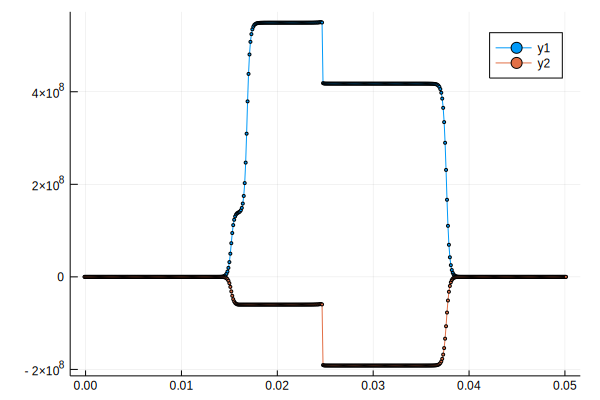

In [238]:
plot(x,uo[:,3:4],marker=2)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))

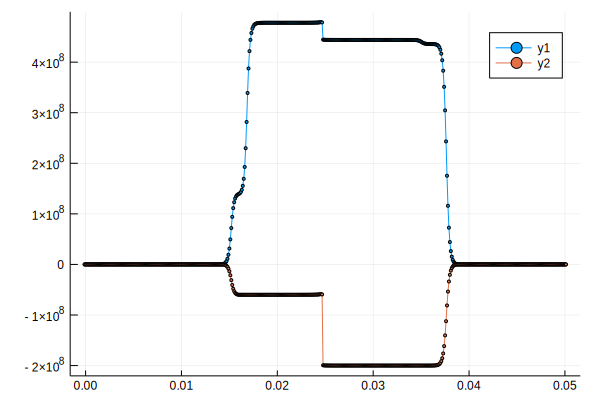

In [241]:
plot(x,uo[:,3:4],marker=2)#xlims = (0.02,0.03), ylims = (4e8,4.2e8))

In [191]:
function HLLCEPNew(u::Array{Float64,1},uL::Array{Float64,2},uR::Array{Float64,2},
        inter::Array{Int,1},problem::Global=problem)

    nv = problem.nv
    jx = problem.nv
   
    I,J = size(uL)
    fL  = zeros(Float64,(I,J))
    fR  = zeros(Float64,(I,J))
    uuh = zeros(Float64,I)
 #   ue = zeros(Float64,J)
    
    for  i in 1:I
           if inter[i] == 1 
            conL = con1
            conR = con1
        else
            conL = con2
            conR = con2
             
        end
        if inter[i]==1 && inter[i+1] == 2
            conL = con1
            conR = con2
       end
       
        
        ρL =  uL[i,1]
        uuL = uL[i,2]
        pL  = uL[i,3]
        sxxL= uL[i,4]
        
        
        varL = Var(ρL,uuL,pL,sxxL)
        σL  = -pL+sxxL
        cL = sound(uL[i,:],conL)
       
        
        ρR =  uR[i,1]
        uuR = uR[i,2]
        pR  = uR[i,3]
        sxxR= uR[i,4]
        
        varR = Var(ρR,uuR,pR,sxxR)        
        σR  = -pR+sxxR 
        cR = sound(uR[i,:],conR)
        
        sL = min(uuL-cL, uuR-cR)
        sR = max(uuL+cL, uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        
        ρL,uuL,pL,sxxL,σL,cL = Plastic(conL,varL,ρLstar,1)
        
        ρR,uuR,pR,sxxR,σR,cR = Plastic(conR,varR,ρRstar,2)      
        
        sL = min(uuL-cL,uuR-cR)
        sR = max(uuL+cL,uuR+cR)
        
        s_star = (σL - σR + ρL*uuL*(sL-uuL) - ρR* uuR*(sR-uuR))/(ρL*(sL-uuL)-ρR*(sR-uuR))
        
        ρLstar = ρL*(uuL-sL)/(s_star - sL)
        ρRstar = ρR*(uuR-sR)/(s_star - sR)
        
        μL = conL.μ
        tmp = -4μL/3*log(ρLstar/ρL) +sxxL
        
        sxxLstar = Yυ(tmp,conL)
        
        μR = conR.μ
        tmp = -4μR/3*log(ρRstar/ρR) +sxxR
        
        sxxRstar = Yυ(tmp,conR)
        
        σstar = σL-ρL*(sL-uuL)*(s_star-uuL)
        pLstar = sxxLstar-σstar
        pRstar = sxxRstar-σstar
        
   #     if s_star > u[i] 
            fL[i,1] = 0
            fL[i,2] = pLstar-sxxLstar
            fL[i,3] = (pLstar-sxxLstar)*s_star
            fL[i,4] = -4μL/3*s_star
            uuh[i] = s_star
#        else
            fR[i,1] = 0
            fR[i,2] = pRstar-sxxRstar
            fR[i,3] = (pRstar-sxxRstar)*s_star
            fR[i,4] = -4μR/3*s_star
            uuh[i] = s_star
  #      end
    end
    return fL,fR, uuh
end

HLLCEPNew (generic function with 2 methods)

In [101]:
function Plastic(con::Const,var::Var,ρstar::Float64,LR::Int)
    Y0= con.Y0 
    ρ0 =con.ρ0
    Γ0 =con.Γ0
    μ  =con.μ 
    a0 =con.a0
    s0 =con.s0
        
    ρ = var.ρ
    uu= var.u
    p = var.p
    sxx=var.sxx
    σ = -p+sxx
    
    ue = zeros(Float64,4)       
    ue[1:4] = [ρ, uu, p ,sxx]
       
    tmp = -4μ/3*log(ρstar/ρ) +sxx
    if (abs(sxx) >=2Y0/3 || abs(tmp) < 2Y0/3)
         c = sound(ue,con)
     
        return ρ,uu,p,sxx,σ,c        
    else
        e = PToe(ρ, p, con) 
        if tmp >= 2Y0/3
           hsxx = 2Y0/3
           hρ  = ρ*exp(-Y0/(2μ)+3sxxL/(4μ))
        else #if tmp <= -2/3*Y0
           hsxx = -2Y0/3
           hρ  = ρ*exp(Y0/(2μ)+3sxx/(4μ))
        end
       t    = 1/ρ-1/hρ
       c0   = 1/(ρ0*Γ0)
       c1   = a0^2/Γ0
       hp   = (2(c1*fη(hρ,con)+e)-t*(σ+hsxx))/(2c0-t)
       hσ = -hp + hsxx
       if (ρstar > ρ && LR ==1)||(ρstar < ρ && LR ==2)
          huu = uu -sqrt((σ-hσ)*t)
       else
          huu = uu +sqrt((σ-hσ)*t)
       end
       ρ   = hρ
       uu  = huu
       p   = hp
       sxx = hsxx
       σ   = hσ
       ue[1:4] = [ρ,uu,p,sxx]
       c = sound(ue,con)
        return ρ,uu,p,sxx,σ,c 
   end
              
end

Plastic (generic function with 1 method)

In [111]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end

@time HLLCEP(uo[:,2],uL,uR,inter)
@time HLLCEPNew(uo[:,2],uL,uR,inter)
@time HLLCEPNew1(uo[:,2],uL,uR,inter)

250
  0.000174 seconds (4.57 k allocations: 190.844 KiB)
  0.001129 seconds (56.38 k allocations: 1000.328 KiB)
  0.000857 seconds (44.31 k allocations: 1.026 MiB)


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])

In [181]:
using Pkg

In [1]:
#ue = zeros(Float64,4)
ue[1:4] = [1, 2, 3 ,4]

LoadError: UndefVarError: ue not defined

In [86]:
function test(c)
    if c^2 < 2
        return c
    else
        for i in 1:100000
            c += sqrt(0.01*c)*exp(0.1*c)-sin(c)
        end
    end
    return c
end
function test1(c)
    if c^2 < 2
        return c
    end
end
@time test(1)
@time test(0.2)
@time test(2)
@time test(3)
@time test(0.5)
@time test1(1)
@time test1(0.2)
@time test1(2)
@time test1(3)
@time test1(0.5)

  0.014499 seconds (34.22 k allocations: 1.789 MiB)
  0.008761 seconds (21.92 k allocations: 1.171 MiB)
  0.002532 seconds (5 allocations: 176 bytes)
  0.003133 seconds (5 allocations: 176 bytes)
  0.000002 seconds (5 allocations: 176 bytes)
  0.004922 seconds (1.96 k allocations: 107.191 KiB)
  0.005580 seconds (8.06 k allocations: 453.139 KiB)
  0.000003 seconds (4 allocations: 160 bytes)
  0.000002 seconds (4 allocations: 160 bytes)
  0.000002 seconds (5 allocations: 176 bytes)


0.5

In [130]:
uo,u,x,inter = TwoMatter1()
I,J =size(uo)
uL = zeros(Float64,(I,J))
uR = zeros(Float64,(I,J))
for i in 1:4
    uL[:,i],uR[:,i] = WENO3(uo[:,i])
end
HLLCEPNew(uo[:,2],uL,uR,inter)

250


([0.0 NaN NaN NaN; 0.0 1.0e-12 5.0e-11 -3.0e12; … ; 0.0 NaN NaN NaN; 0.0 NaN NaN NaN], [NaN, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0  …  -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, NaN, NaN])